In [42]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [43]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt

In [44]:
# Set random seeds for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Load Data

In [45]:
# load the dataset, split into input (X) and output (y) variables
dataset = np.loadtxt('/kaggle/input/digit-recognizer/train.csv', delimiter=',', skiprows=1)
X = dataset[:,1:]
print(X)
y = dataset[:, 0]
print(y)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[1. 0. 1. ... 7. 6. 9.]


In [46]:
# Normalize the training data
X = X / 255.0  # Normalize pixel values to [0, 1]

In [47]:
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.int64)  # Class indices should be int64

Define PyTorch Model

In [48]:
model = nn.Sequential(
    nn.Linear(784, 300),
    nn.ReLU(),
    nn.Linear(300, 300),
    nn.ReLU(),
    nn.Linear(300, 10)
)

print(model)

Sequential(
  (0): Linear(in_features=784, out_features=300, bias=True)
  (1): ReLU()
  (2): Linear(in_features=300, out_features=300, bias=True)
  (3): ReLU()
  (4): Linear(in_features=300, out_features=10, bias=True)
)


Define Loss Function and Optimizers

In [49]:
loss_fn = nn.CrossEntropyLoss()  # binary cross entropy
optimizer = optim.Adam(model.parameters(), lr=0.001)

Run a Training Loop

In [50]:
# Run the training loop
n_epochs = 10
batch_size = 10

for epoch in range(n_epochs):
    for i in range(0, len(X), batch_size):
        Xbatch = X[i:i + batch_size]
        ybatch = y[i:i + batch_size]

        # Forward pass
        y_pred = model(Xbatch)

        # Compute loss
        loss = loss_fn(y_pred, ybatch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Finished epoch {epoch}, latest loss {loss.item()}')

Finished epoch 0, latest loss 0.011259687133133411
Finished epoch 1, latest loss 0.003818848403170705
Finished epoch 2, latest loss 0.006110035814344883
Finished epoch 3, latest loss 0.015534898266196251
Finished epoch 4, latest loss 0.0027508747298270464
Finished epoch 5, latest loss 0.00031496776500716805
Finished epoch 6, latest loss 0.01851588487625122
Finished epoch 7, latest loss 3.1828651572141098e-06
Finished epoch 8, latest loss 6.914123673595896e-07
Finished epoch 9, latest loss 9.881967343972065e-06


Evaluate the Model

In [51]:
# Evaluate the model
with torch.no_grad():
    y_pred = model(X)
    predictions = torch.argmax(y_pred, dim=1)
    accuracy = (predictions == y).float().mean()
    print(f"Accuracy: {accuracy.item()}")

Accuracy: 0.9940476417541504


Make Predictions

In [52]:
# Load the test dataset
test_data_path = '/kaggle/input/digit-recognizer/test.csv'
test_df = pd.read_csv(test_data_path)

# Prepare the test data
test_X = test_df.values
test_X = test_X / 255.0  # Normalize pixel values to [0, 1]
test_X = torch.tensor(test_X, dtype=torch.float32)

model.eval()

# Make predictions
with torch.no_grad():
    outputs = model(test_X)
    test_predictions = torch.argmax(outputs, dim=1).numpy()

# Create a DataFrame with ImageId and Label
image_ids = np.arange(1, len(test_predictions) + 1)  # Assuming ImageId starts from 1
submission_df = pd.DataFrame({
    'ImageId': image_ids,
    'Label': test_predictions
})

# Save to CSV file
submission_df.to_csv('submission.csv', index=False)

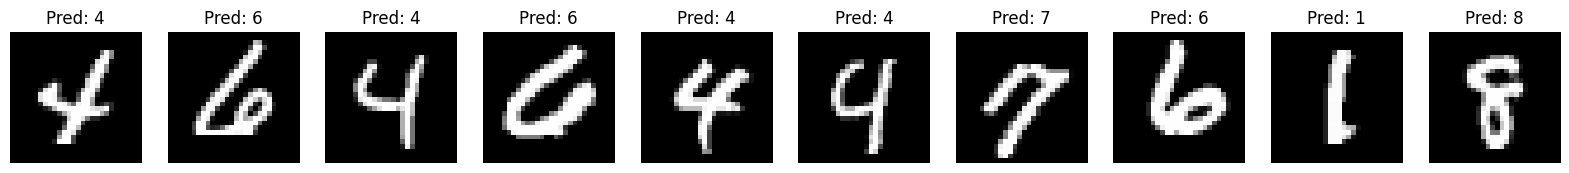

In [53]:
# Select a few samples to visualize
num_samples = 10
sample_indices = np.random.choice(len(test_X), num_samples, replace=False)
sample_images = test_X[sample_indices].numpy()
sample_predictions = test_predictions[sample_indices]

# Visualize the samples along with their predicted labels
fig, axes = plt.subplots(1, num_samples, figsize=(20, 2))
for i, ax in enumerate(axes):
    ax.imshow(sample_images[i].reshape(28, 28), cmap='gray')
    ax.set_title(f'Pred: {sample_predictions[i]}')
    ax.axis('off')
plt.show()